In [1]:
import shutup
shutup.please()

In [2]:
import os
import numpy as np
import random

from src.agents.agent import Agent
from src.utils.buffer import Buffer

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Model

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()


In [6]:
import numpy as np

class ReplayBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.size = 0

    def reset(self):
        self.size = 0
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()

    def remember(self, state, action_onehot, reward ):
        self.size +=1
        self.states.append(state)
        self.actions.append(action_onehot)
        self.rewards.append(reward)

#     def sample(self, batch_size=64):
#         max_mem = min(self.buffer_counter, self.buffer_size)

#         batch = np.random.choice(max_mem, batch_size)

#         states = self.state_memory[batch]
#         states_ = self.new_state_memory[batch]
#         actions = self.action_memory[batch]
#         rewards = self.reward_memory[batch]
#         dones = self.done_memory[batch]

#         return states, actions, rewards, states_, dones

In [11]:
from src.agents.agent import Agent
from src.utils.networks import CommonLayer
    

class A2CAgent(Agent):
    def __init__(self,
                environment,
                gamma = 0.99,
                policy="mlp",
                actor_optimizer=RMSprop(0.0001),
                critic_optimizer=RMSprop(0.0001),
                std_bound = [1e-2, 1.0],
                batch_size=64
                ):
        super(A2CAgent, self).__init__(environment,args=locals())
        
        # Args
        self.gamma = gamma
        self.std_bound = std_bound
        self.batch_size = batch_size
        self.policy = policy 
        self.actor_optimizer=actor_optimizer
        self.critic_optimizer=critic_optimizer

        # Bootstrap
        self.__init_networks()
        self.__init_buffers()
        self._add_models_to_config([self.actor,self.critic])
        
    def __init_networks(self):
        X_input = Input(shape=self.observation_shape) 
        X = CommonLayer(X_input,self.policy)
        
        action = Dense(self.n_actions, activation="softmax", kernel_initializer='he_uniform')(X)
        value = Dense(1, kernel_initializer='he_uniform')(X)
        
        if self.action_space_mode == "discrete":
            action = Dense(self.n_actions, activation="softmax", kernel_initializer='he_uniform')(X)
            self.actor = Model(inputs = X_input, outputs = action)
            self.actor.compile(loss='categorical_crossentropy', optimizer=self.actor_optimizer)
        else:
            mu = Dense(self.n_actions, activation="tanh", kernel_initializer='he_uniform')(X)
            mu = Lambda(lambda x: x * self.action_bound)(mu)
            sigma = Dense(self.n_actions, activation="softplus", kernel_initializer='he_uniform')(X)
            
            self.actor = Model(inputs = X_input, outputs = Concatenate()([mu,sigma]))
            self.actor.compile(loss=self.continuous_actor_loss, optimizer=self.actor_optimizer)
        
        self.critic = Model(inputs = X_input, outputs = value)
        self.critic.compile(loss='mse', optimizer=self.critic_optimizer)
    
    def __init_buffers(self):
        self.buffer = ReplayBuffer()
        
    def log_pdf(self,mu, sigma, action):
        std = tf.clip_by_value(sigma, self.std_bound[0], self.std_bound[1])
        var = std ** 2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / var - 0.5 * tf.math.log(
            var * 2 * np.pi
        )
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)
    
    def continuous_actor_loss(self, y_true, y_pred):
        actions, advantages = y_true[:, :1], y_true[:, 1:]
        mu,sigma = y_pred[:,:1], y_pred[:,1:]
        log_policy_pdf = self.log_pdf(mu,sigma,actions)
        loss_policy = log_policy_pdf * advantages
        
        return tf.reduce_sum(-loss_policy)

    def act(self,state):
        if self.action_space_mode == "discrete":
            prediction = self.actor.predict(state)[0]
            action = np.random.choice(self.n_actions, p=prediction)
            action_onehot = np.zeros([self.n_actions])
            action_onehot[action] = 1
        else:
            prediction = self.actor.predict(state)[0]
            mu = prediction[0]
            sigma = prediction[1]
            action = np.random.normal(mu, sigma,self.n_actions)
            action = np.clip(action, -self.action_bound, self.action_bound)
            action_onehot = action
        return action, action_onehot, prediction
    
    def discount_rewards(self, reward):
        # Compute the gamma-discounted rewards over an episode
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            running_add = running_add * self.gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= (np.std(discounted_r) + 1e-8) # divide by standard deviation
        
        return discounted_r
    
    def replay(self):

        if self.buffer.size > 1:
            # reshape memory to appropriate shape for training
            states = np.vstack(self.buffer.states)
            actions = np.vstack(self.buffer.actions)

            # Compute discounted rewards
            discounted_r = self.discount_rewards(self.buffer.rewards)

            # Get Critic network predictions
            values = self.critic.predict(states)[:, 0]
            # Compute advantages
            advantages = discounted_r - values
            # training Actor and Critic networks


            if self.action_space_mode == "discrete":
                self.actor.fit(states, actions, sample_weight=advantages, epochs=1, verbose=0)
            else:
                self.actor.fit(states,np.concatenate([actions,np.reshape(advantages,newshape=(len(advantages),1))],axis=1), epochs=1,verbose=0)

            self.critic.fit(states, discounted_r, epochs=1, verbose=0)
            # reset training memory
            self.buffer.reset()
        
    def learn(self, timesteps=-1, plot_results=True, reset=False, success_threshold=False, log_level=1, log_each_n_episodes=50):
        self.validate_learn(timesteps,success_threshold,reset)
        success_threshold = success_threshold if success_threshold else self.env.success_threshold
 
        score = 0
        timestep = 0
        episode = 0
        
        while self.learning_condition(timesteps,timestep):  # Run until solved
            state = self.env.reset()
            score = 0
            done = False
            
            while not done:
                
                state = np.expand_dims(state, axis=0)
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                self.buffer.remember(state, action_onehot, reward)
                # Update current state
                state = next_state
                score += reward
                timestep +=1
                
                if self.buffer.size >= self.batch_size:
                    self.replay()
            
            # Episode ended
            self.running_reward.step(score)
            episode += 1
            
            self.learning_log.episode(
                log_each_n_episodes,
                score,
                self.running_reward.reward, 
                log_level=log_level
            )
            # If done stop
            if self.did_finnish_learning(success_threshold,episode):
                break
                
            # Else learn more
            self.replay()
        
        # End of trainig
        self.env.close()
        
        if plot_results:
            self.plot_learning_results()


| ---------------------------------
| CartPole-v1
| Action space: Discrete with high state-space
| Environment beated threshold: 200
| Dev notes:
|   * Agents that track State/Action combinations like 
|     Q learning will fail due to high state space
| ----------------------------------------------------------   


Episode * 50 * Moving Avg Reward is ==> 24.580 * Last Reward was ==> 25.000
Episode * 100 * Moving Avg Reward is ==> 26.360 * Last Reward was ==> 9.000
Episode * 150 * Moving Avg Reward is ==> 24.380 * Last Reward was ==> 46.000
Episode * 200 * Moving Avg Reward is ==> 27.920 * Last Reward was ==> 21.000
Episode * 250 * Moving Avg Reward is ==> 24.320 * Last Reward was ==> 17.000
Episode * 300 * Moving Avg Reward is ==> 29.400 * Last Reward was ==> 55.000
Episode * 350 * Moving Avg Reward is ==> 32.160 * Last Reward was ==> 34.000
Episode * 400 * Moving Avg Reward is ==> 34.020 * Last Reward was ==> 31.000
Episode * 450 * Moving Avg Reward is ==> 38.560 * Last Reward was 

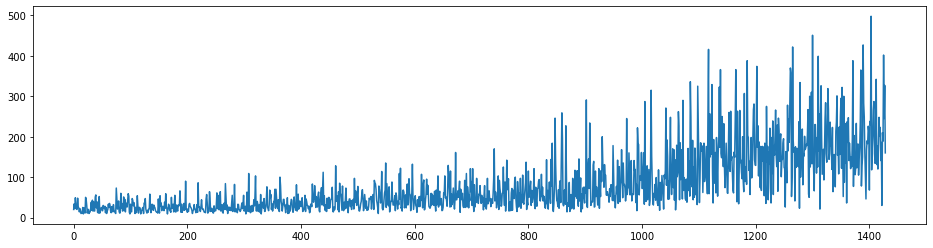

In [12]:
from src.environments.discrete.cartpole import environment
agent = A2CAgent(environment)
agent.learn()

Episode * 50 * Moving Avg Reward is ==> 27.720 * Last Reward was ==> 14.000
Episode * 100 * Moving Avg Reward is ==> 27.000 * Last Reward was ==> 21.000
Episode * 150 * Moving Avg Reward is ==> 28.880 * Last Reward was ==> 28.000
Episode * 200 * Moving Avg Reward is ==> 28.320 * Last Reward was ==> 28.000
Episode * 250 * Moving Avg Reward is ==> 30.740 * Last Reward was ==> 33.000
Episode * 300 * Moving Avg Reward is ==> 43.620 * Last Reward was ==> 27.000
Episode * 350 * Moving Avg Reward is ==> 36.040 * Last Reward was ==> 32.000
Episode * 400 * Moving Avg Reward is ==> 37.040 * Last Reward was ==> 23.000
Episode * 450 * Moving Avg Reward is ==> 50.040 * Last Reward was ==> 70.000
Episode * 500 * Moving Avg Reward is ==> 58.780 * Last Reward was ==> 99.000
Episode * 550 * Moving Avg Reward is ==> 62.720 * Last Reward was ==> 42.000
Episode * 600 * Moving Avg Reward is ==> 75.220 * Last Reward was ==> 48.000
Episode * 650 * Moving Avg Reward is ==> 81.180 * Last Reward was ==> 151.000

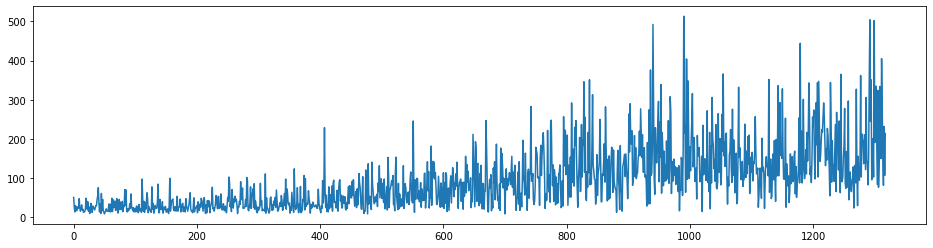

In [13]:
from src.environments.continuous.inverted_pendulum import environment
agent = A2CAgent(environment)
agent.learn()

